# Problem Set 3, due Wednesday, May 3rd, 5:30pm.

## Introduction to the assignment

For this assignment, you will be using data from the [Progresa
program](http://en.wikipedia.org/wiki/Oportunidades), a government
social assistance program in Mexico. This program, as well as the
details of its impact, are described in the paper "[School subsidies
for the poor: evaluating the Mexican Progresa poverty
program](http://www.sciencedirect.com/science/article/pii/S0304387803001858)",
by Paul Shultz (available on Canvas).  The data
(progresa_sample.csv.gz) is available on canvas
in files/data.

Please read the paper to familiarize yourself with
the PROGRESA program before beginning this problem set, so you have a
rough sense of where the data come from and how they were
generated. If you just proceed into the problem set without
understanding Progresa or the data, it will be very difficult!

The goal of this problem set is to implement some of the basic
econometric techniques that you are learning in class to measure the
impact of Progresa on secondary school enrollment rates, in particular
differences-in-differences.  Your task is to **estimate the impact of
_progresa_ subsidies on the school attendance**.  Note: this asks to
estimate a causal effect.

The timeline of the program was:

 * Baseline survey conducted in 1997
 * Intervention begins in 1998, "Wave 1" of data collected in 1998
 * "Wave 2 of data" collected in 1999
 * Evaluation ends in 2000, at which point the control villages were treated. 
 
When you are ready, download the progresa_sample.csv data from
Canvas. The data are actual data collected to evaluate the impact of
the Progresa program.  In this file, each row corresponds to an
observation taken for a given child for a given year. There are two
years of data (1997 and 1998), and just under 40,000 children who are
surveyed in both years.  For each child-year observation, the
following variables are collected:

| Variable name | Description|
|------|------|
|year	  |year in which data is collected
|sex	  |male = 1|
|indig	  |indigenous = 1|
|dist_sec |nearest distance to a secondary school|
|sc	      |enrolled in school in year of survey (=1)|
|grc      |grade enrolled|
|fam_n    |family size|
|min_dist |	min distance to an urban center|
|dist_cap |	min distance to the capital|
|poor     |	poor = "pobre", not poor = "no pobre"|
|progresa |treatment = "basal", control = "0"|
|hohedu	  |years of schooling of head of household|
|hohwag	  |monthly wages of head of household|
|welfare_index|	welfare index used to classify poor|
|hohsex	|gender of head of household (male=1)|
|hohage	|age of head of household|
|age	|years old|
|folnum	|individual id|
|village|	village id|
|sc97	|enrolled in school in 1997 (=1) |

In [166]:
# Import the required modules

import numpy as np

import pandas as pd
print( "Pandas version:       %6.6s (need at least 0.11.0)" % pd.__version__)

import matplotlib.pyplot as plt
%matplotlib inline

import scipy as sp
from scipy import stats

import statsmodels.formula.api as smf

Pandas version:       0.22.0 (need at least 0.11.0)


## Part 1: Descriptive analysis

### 1.1	Summary Statistics

Report summary statistics (mean, standard deviation, and number of missings) for all of
the demographic variables in the dataset (i.e., everything except
year, folnum, village).  Present the actual levels for 'progresa' and
'poor'.  Do these fit with the documentation above?

Present these in a single table alphabetized
by variable name. Do NOT simply expect the grader to scroll through
your output!

In [152]:
# Read the progresa data
progresa_df = pd.read_csv("progresa_sample.csv.gz")

In [5]:
# Explore the data
progresa_df.head()

,year,sex,indig,dist_sec,sc,grc,fam_n,min_dist,dist_cap,poor,...,hohedu,hohwag,welfare_index,hohsex,hohage,age,village,folnum,grc97,sc97
0,97,0.0,0.0,4.473,1.0,7.0,7,21.168384,21.168384,pobre,...,6,0.0,583.0,1.0,35.0,13,163,1,7,1.0
1,98,0.0,0.0,4.473,1.0,8.0,7,21.168384,21.168384,pobre,...,6,0.0,583.0,1.0,35.0,14,163,1,7,1.0
2,97,1.0,0.0,4.473,1.0,6.0,7,21.168384,21.168384,pobre,...,6,0.0,583.0,1.0,35.0,12,163,2,6,1.0
3,98,1.0,0.0,4.473,1.0,7.0,7,21.168384,21.168384,pobre,...,6,0.0,583.0,1.0,35.0,13,163,2,6,1.0
4,97,0.0,0.0,4.473,1.0,2.0,7,21.168384,21.168384,pobre,...,6,0.0,583.0,1.0,35.0,8,163,3,2,1.0


In [28]:
# Exclude columns for which summary statistics are not being computed
progresa_reduced = progresa_df[progresa_df.columns.difference(['year', 'folnum', 'village', 'poor', 'progresa'])]

In [192]:
# Create and display a new data frame for the summary statistics
results = pd.DataFrame({'Mean': progresa_reduced.mean(), 'Standard Deviation': progresa_reduced.std(), 'Missing Count': progresa_reduced.isnull().sum()})
results.index.name = "Variable"
results.reset_index(inplace=True)
results

,Variable,Mean,Missing Count,Standard Deviation
0,age,11.366460,0,3.167744
1,dist_cap,147.674452,0,76.063134
2,dist_sec,2.418910,0,2.234109
3,fam_n,7.215715,0,2.352900
4,grc,3.963537,6549,2.499063
5,grc97,3.705372,0,2.572387
6,hohage,44.436717,10,11.620372
7,hohedu,2.768104,0,2.656106
8,hohsex,0.925185,20,0.263095
9,hohwag,586.985312,0,788.133664


In [45]:
print("Coding for 'progresa' column:", progresa_df['progresa'].unique())
print("Coding for 'poor' column:", progresa_df['poor'].unique())

Coding for 'progresa' column: ['0' 'basal']
Coding for 'poor' column: ['pobre' 'no pobre']


The actual levels for the fields 'progresa' and 'poor' are the same as those in the documentation. There are no coding errors/ missing values for the two fields, since there are no unexpected values in the results of the unique() function.

### 1.2 Differences at baseline?
Now let's investigate the differences in baseline.  Are the baseline (1997) demographic characteristics **for the poor**
different in treatment and control villages?

I suggest you to use a T-Test to
determine whether there is a statistically significant difference in
the average values of each of the variables in the dataset. Focus only
on the data from 1997 for poor.

Present your results in a single table with the following columns and 14 (or so) rows:

| Variable name | Average value (Treatment villages) | Average value (Control villages) | Difference (Treat - Control) | p-value |
|------|------|------|------|------|
|Male|?|?|?|?|


In [264]:
# Select rows where the year is 1997, and the individuals classified as poor
progresa_filtered = progresa_df[np.logical_and(progresa_df['year'] == 97, progresa_df['poor'] == 'pobre')]
progresa_filtered = progresa_filtered[progresa_df.columns.difference(['year', 'folnum', 'village', 'poor', 'grc'])]
pvalues = [] # an empty list to store computed p-values
progresa_treat = progresa_filtered[progresa_filtered['progresa'] == 'basal']  # Select treatment rows
progresa_treat = progresa_treat[progresa_treat.columns.difference(['progresa'])]
progresa_control = progresa_filtered[progresa_filtered['progresa'] == '0']   # Select control rows
progresa_control = progresa_control[progresa_control.columns.difference(['progresa'])]

# Iterate over all the columns and record p-values after performing a t-test
for column in progresa_treat.columns:
    pvalues.append(stats.ttest_ind(progresa_treat[column].dropna(), progresa_control[column].dropna()).pvalue)    

# Compute average values for the various fields, separately for treatment and control rows
progresa_ttest = progresa_filtered.groupby('progresa').mean()

# Organize the results into a dataframe
progresa_ttest_results = pd.DataFrame({'Average value (Control villages)': progresa_ttest.loc['0'], 
                                       'Average value (Treatment villages)': progresa_ttest.loc['basal'],
                                       'Difference(Treat - Control)': progresa_ttest.loc['basal'] - progresa_ttest.loc['0'],
                                       'p-value' : pvalues},
                                      columns=['Average value (Treatment villages)', 'Average value (Control villages)',
                                              'Difference(Treat - Control)','p-value'], 
                                      index = pd.Series(progresa_ttest.columns))
progresa_ttest_results.index.name = "Variable Name"
progresa_ttest_results.reset_index(inplace= True)
progresa_ttest_results


,Variable Name,Average value (Treatment villages),Average value (Control villages),Difference(Treat - Control),p-value
0,age,10.716991,10.742023,-0.025032,4.785594e-01
1,dist_cap,150.829074,153.769730,-2.940656,8.415005e-04
2,dist_sec,2.453122,2.507662,-0.054540,3.569843e-02
3,fam_n,7.281327,7.302469,-0.021142,4.271039e-01
4,grc97,3.531599,3.543050,-0.011450,6.890151e-01
5,hohage,43.648828,44.276918,-0.628090,1.796243e-06
6,hohedu,2.663139,2.590348,0.072791,1.105093e-02
7,hohsex,0.924656,0.922947,0.001709,5.711858e-01
8,hohwag,544.339544,573.163558,-28.824015,3.253835e-04
9,indig,0.325986,0.332207,-0.006222,2.453603e-01


### 1.3 Interpretation

* A: Are there statistically significant differences between treatment and control villages as baseline? 
* B: Why does it matter if there are differences at baseline?
* C: What does this imply about how to measure the impact of the treatment?

**Observations**
* A: Yes, there are statistically significant differences between treatment and control villages as baseline. The differences in average/expected values for treatment and control villages are significant for the following fields:
    1. dist_cap - min distance to the capital
    2. dist_sec - nearest distance to a secondary school
    3. hohage - age of head of household
    4. hohedu - years of schooling of head of household
    5. hohwag - monthly wages of head of household
    6. min_dist - min distance to an urban center
    7. sex - male = 1
    8. welfare_index - welfare index used to classify poor
    
* B: If there are differences at baseline between treatment and control, we can suffer from the 'curse of the counterfactual'. In other words, we ideally want to measure the effect of the treatment on particular individuals, before and after the intervention. However, since we cannot observe the same indivdual both with and without treatment, we select control cases with similar characteristics to those of the treatment cases. If there are significant differences at baseline between the treatment and controls, our causal inference can be inaccurate, since the net effect of the intervention could be influenced by the difference at baseline.

* C: In order to accurately measure the impact of the treatment, we need to be able to account for the differences at baseline for treatment and control cases. This is can be achieved through Diff-in-Diff estimators. However, if the covariates in treatment and control cases are quite different (not a pure randomized control trial), as is the case here, there is still a risk of over-estimating or under-estimating the impact.


### 1.4 Graphical exploration, part 1

For each level of household head education, compute the average
enrollment rate in 1997. Create a scatterplot that shows this
relationship. What do you notice?

In [170]:
# Group records by Education Level of the household head, computing mean enrollment rate for each group.
hohedu_df = pd.DataFrame(progresa_df.groupby('hohedu').sc97.mean())

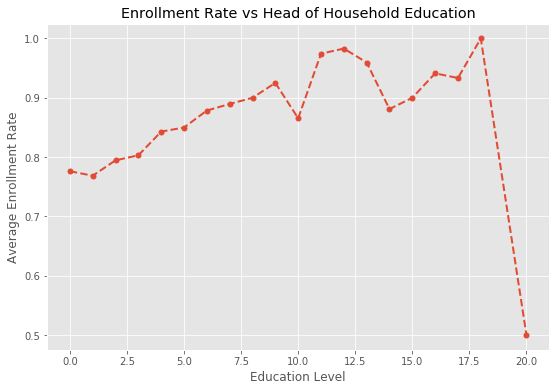

In [171]:
# Create a scatter plot to depict variation in enrollment rates
plt.style.use('ggplot')
fig_month = plt.figure(figsize=(9,6))
props_axes = {
    'title': 'Enrollment Rate vs Head of Household Education',
    'xlabel': 'Education Level',
    'ylabel': 'Average Enrollment Rate'  
}
axes = fig_month.add_subplot(111)
axes.set(**props_axes)
_ = axes.plot(hohedu_df.index.values, hohedu_df['sc97'], marker='o', linestyle='dashed', linewidth=2, markersize=5)

We observe from the above plot that the enrollment rate generally increases with an increase in the education level of the household head. There seems to be a rather steep drop in the enrollment rate where household heads have more than 18 years of education. Let's explore this further by checking the number of such records.

In [194]:
# Select records where household head has 18 years or more of education
progresa_df[progresa_df['hohedu'] > 18 ]

,year,sex,indig,dist_sec,sc,grc,fam_n,min_dist,dist_cap,poor,...,hohedu,hohwag,welfare_index,hohsex,hohage,age,village,folnum,grc97,sc97
45238,97,1.0,1.0,4.302,0.0,9.0,3,141.893448,284.166918,pobre,...,20,0.0,797.0,0.0,49.0,16,434,22620,9,0.0
45239,98,1.0,1.0,4.302,NaN,NaN,3,141.893448,284.166918,pobre,...,20,0.0,797.0,0.0,49.0,17,434,22620,9,0.0
45240,97,1.0,1.0,4.302,1.0,7.0,3,141.893448,284.166918,pobre,...,20,0.0,797.0,0.0,49.0,14,434,22621,7,1.0
45241,98,1.0,1.0,4.302,NaN,NaN,3,141.893448,284.166918,pobre,...,20,0.0,797.0,0.0,49.0,15,434,22621,7,1.0


There are only 4 such records, and therefore it is difficult to come to any conclusion about this particular case with the limited data that we have. Therefore, we stick to our conclusion that in general, the enrollment rate increases as the household heads are more educated.

### 1.5 Graphical exploration, part 2

Create a histogram of village enrollment rates **among poor households
in treated villages**, before and after treatment.  Specifically, for
each village, calculate the average rate of enrollment of poor
households in treated villages in 1997, then compute the average rate
of enrollment of poor households in treated villages in 1998. Create
two separate histograms showing the distribution of these average
enrollments rates, one histogram for 1997 and one histogram for
1998. On each histogram, draw a vertical line that intersects the
x-axis at the average value (across all households). Does there appear
to be a difference? Is this difference statistically significant?

Text(0.829536,10,'0.83')

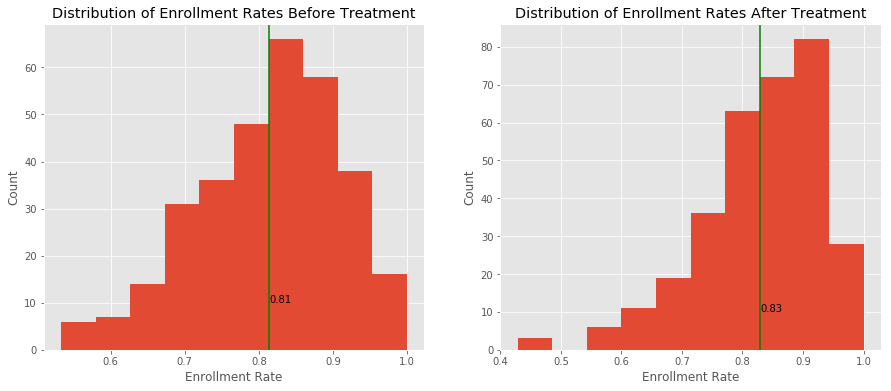

In [267]:
# Select poor households from the treatment group
progresa_filtered = progresa_df[np.logical_and(progresa_df['poor'] == 'pobre', progresa_df['progresa'] == 'basal')]
# Create dataframe of village-wise enrollment rates before the treatment
progresa_filtered_before = pd.DataFrame(progresa_filtered[progresa_filtered['year'] == 97].groupby('village').sc97.mean())
# Create dataframe of village-wise enrollment rates after the treatment
progresa_filtered_after = pd.DataFrame(progresa_filtered[progresa_filtered['year'] == 98].groupby('village').sc.mean())

# Overall mean before
mean_before = progresa_filtered_before['sc97'].mean()
# Overall mean after
mean_after = progresa_filtered_after['sc'].mean()
# Plot the histograms
plt.style.use('ggplot')
fig_month = plt.figure(figsize=(15,6))
props_axes = {
    'title': 'Distribution of Enrollment Rates Before Treatment',
    'xlabel': 'Enrollment Rate',
    'ylabel': 'Count'  
}
axes = fig_month.add_subplot(121)
axes.set(**props_axes)
_ = axes.hist(progresa_filtered_before['sc97'])
plt.axvline(x=mean_before, color = "green")
plt.text(mean_before, 10, round(mean_before, 2))

props_axes = {
    'title': 'Distribution of Enrollment Rates After Treatment',
    'xlabel': 'Enrollment Rate',
    'ylabel': 'Count'  
}
axes = fig_month.add_subplot(122)
axes.set(**props_axes)
_ = axes.hist(progresa_filtered_after['sc'])
plt.axvline(x=mean_after, color = "green")
plt.text(mean_after, 10, round(mean_after, 2))

In [268]:
stats.ttest_ind(progresa_filtered_before['sc97'], progresa_filtered_after['sc'])

Ttest_indResult(statistic=-2.015713486515638, pvalue=0.04424870036572115)

The histograms above show that there seems to be a difference in the average enrollment rate for the households before and after the intervention. Also, the results from the t-test show that the p-value is smaller than our significance level of 0.05. Therefore the differences in average enrollment, before and after the intervention are statistically significant.

## Part 2: Measuring Impact

Our goal is to estimate the causal impact of the PROGRESA program on
the social and economic outcomes of individuals in Mexico. We will
focus on the impact of the program on the poor (those with
poor=='pobre'), since only the poor were eligible to receive the
PROGRESA assistance.

### 2.1 Cross-Sectional Estimator: T-test

Begin by estimating the impact of Progresa using "simple differences."
Restricting yourself to data from 1998 (after treatment), calculate
the average enrollment rate among **poor** households in the Treatment
villages and the average enrollment rate among **poor** households in
the control villages. Use a t-test to determine if this difference is
statistically significant. What do you conclude?

In [265]:
# Select rows for poor households, year 1998
progresa_filtered = progresa_df[np.logical_and(progresa_df['year'] == 98, progresa_df['poor'] == 'pobre')]
# Group by treatment/control and compute the mean enrollment rate
progresa_filtered.groupby('progresa').sc.mean()

progresa
0        0.807637
basal    0.846479
Name: sc, dtype: float64

In [266]:
stats.ttest_ind(progresa_filtered[progresa_filtered['progresa'] == '0']['sc'].dropna(), 
                progresa_filtered[progresa_filtered['progresa'] == 'basal']['sc'].dropna())

Ttest_indResult(statistic=-8.358720567418374, pvalue=6.636344447523235e-17)

We observe that there is a difference in average enrollment among poor households from Treatment villages and those from Control villages. The enrollment is approximately 4% more in households from Treatment villages. This difference is also statistically significant, as indicated by the p-value from the t-test above. Therefore, based on the Cross Sectional Estimator, we can say that Progresa has increased the likelihood of enrollment for treatment cases compared to the control cases (with the underlying counterfactual assumption).

### 2.2 Cross-Sectional Estimator: Regression

Estimate the effects of Progresa on enrollment using a regression
model, by regressing the 1998 enrollment rates **of the poor** on
treatment assignment.  Do not include any additional control
variables.
Discuss the following:

* Based on this model, how much did Progresa increase the likelihood of a child enrolling?
* How does your regression estimate compare to your t-test estimate from part 2.1?
* Based on this regression model, can we reject the null hypothesis that the treatment effects are zero? 
* What is the counterfactual assumption underlying this regression?

Note: I recommend to use statsmodels.formula.api as this allows to use
convenient R-style formulas and provedes nice summaries of the results.

In [175]:
m1 = smf.ols(formula = 'sc ~ C(progresa)', data = progresa_filtered).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     65.64
Date:                Sat, 28 Apr 2018   Prob (F-statistic):           5.66e-16
Time:                        18:43:16   Log-Likelihood:                -11171.
No. Observations:               26155   AIC:                         2.235e+04
Df Residuals:                   26153   BIC:                         2.236e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.8109      0.004    217.190      0.000       0.804       0.818
progresa[T.basal]     0.0383      0.005      8.102      0.000       0.029       0.048
==============================================================================
Omnibus:                     7487.800   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15756.374
Skew:                          -1.796   Prob(JB):                         0.00
Kurtosis:                       4.245   Cond. No.                         3.02
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* We see that our treatment Progresa is associated with an increase in likelihood of enrollment by 0.038 ~ 0.04 percent.
* The regression estimate is in agreement with the t-test estimate, with the Intercept giving the likelihood of enrollment for control households (0.8109, same as that calculated in section 2.1) and  Intercept + progresa\[T.basal\] giving the likelihood for treatment households (0.8492, same as that calculated in section 2.1).
* Yes, we can reject the null hypothesis for treatment effect being 0, since the p-value for the progresa\[T.basal\] coefficient is less than the significance value of 0.05
* The counterfactual assumption here is that if the treatment (Progresa) were not given, there would be no difference in enrollment between the treatment and control groups.

### 2.3 Multiple Regression

Re-run the above regression estimated but this time include a set of
relevant control variables. Include, for instance, age, distance to a secondary
school, gender, education of household head, welfare index,
indigenous, etc.


In [205]:
m2 = smf.ols(formula = 'sc ~ C(progresa) + age + dist_sec + C(sex) + C(indig) + hohwag + hohedu', data = progresa_filtered).fit()
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     1335.
Date:                Sat, 28 Apr 2018   Prob (F-statistic):               0.00
Time:                        23:18:56   Log-Likelihood:                -7208.0
No. Observations:               26155   AIC:                         1.443e+04
Df Residuals:                   26147   BIC:                         1.450e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.5220      0.010    155.036      0.000       1.503       1.541
progresa[T.basal]     0.0348      0.004      8.557      0.000       0.027       0.043
C(sex)[T.1.0]         0.0308      0.004      7.807      0.000       0.023       0.039
C(indig)[T.1.0]       0.0491      0.004     11.542      0.000       0.041       0.057
age                  -0.0650      0.001    -92.566      0.000      -0.066      -0.064
dist_sec             -0.0110      0.001    -11.830      0.000      -0.013      -0.009
hohwag            -2.306e-06   2.82e-06     -0.816      0.414   -7.84e-06    3.23e-06
hohedu                0.0083      0.001     10.361      0.000       0.007       0.010
==============================================================================
Omnibus:                     3020.361   Durbin-Watson:                   1.718
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4179.787
Skew:                          -0.968   Prob(JB):                         0.00
Kurtosis:                       3.293   Cond. No.                     4.58e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* **How do the controls affect the point estimate of treatment effect? **  
Introducing the controls slightly reduces the value of the coefficient progresa\[T.basal\], however, the result is still statistically significant. Keeping the other controls fixed, we see that the likelihood of enrollment for treatment cases is reduced from 0.0383 to 0.0348.
* **How do the controls affect the standard error on the treatment effect? **  
The standard error in the treatment effect is slightly reduced from 0.005 to 0.004 by the introduction of the controls.
* **How do you interpret the differences (or similarities) between your estimates of 2.2 and 2.3?**  
The results are similar to section 2.2 in the sense that the effect of progresa in the treatment cases is roughly the same (with the counterfactual assumption). In addition, we see that this model has an R-squared value of 0.26, compared to a value of 0.003 in the previous model (when controls were not introduced). This model is therefore able to better explain the variability in the outcome variable than our previous model.

### 2.4 Difference-in-Difference, version 1 (tabular)

Thus far, we have computed the effects of Progresa by estimating the
difference in 1998 enrollment rates across villages. An alternative
approach would be to compute the treatment effect using a
difference-in-differences framework.

Begin by estimating the average treatment effects of the program for poor households using data from 1997 and 1998. Specifically, calculate:

a) the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages

b) the difference (between 1997 and 1998) in enrollment rates among poor households in control villages.

c) The difference between these two differences is your estimate.



**a)**

In [241]:
progresa_treat = progresa_df[np.logical_and(progresa_df['poor'] == 'pobre', progresa_df['progresa'] == 'basal')]
treat_series = progresa_treat.groupby('year').sc.mean()
print(treat_series)
diff_treat = treat_series.values[1] - treat_series.values[0]
print("Difference in treated villages from 97 to 98 = ", round(diff_treat, 4))

year
97    0.822697
98    0.846479
Name: sc, dtype: float64
Difference in treated villages from 97 to 98 =  0.023782233992046597


**b)**

In [260]:
progresa_control = progresa_df[np.logical_and(progresa_df['poor'] == 'pobre', progresa_df['progresa'] == '0')]
control_series = progresa_control.groupby('year').sc.mean()
print(control_series)
diff_control = control_series.values[1] - control_series.values[0]
print("Difference in control villages from 97 to 98 = ", round(diff_control, 4))

year
97    0.815186
98    0.807637
Name: sc, dtype: float64
Difference in control villages from 97 to 98 =  -0.0075


**c)**

In [259]:
print("Diff-in-diff = ", round(diff_treat - diff_control,4))

Diff-in-diff =  0.0313


* **What is your estimate of the impact, and how does it compare to your earlier (simple difference) results?  **  
The estimate of the impact is 0.0313 (~ 3%), which is slightly less than our estimate of roughly 0.04 using Cross Sectional Estimator.
* ** What is the counterfactual assumption underlying this estimate?  **  
The counterfactual assumption here is the 'parallel paths' assumption, i.e., the average change in enrollment in the control villages represents the counterfactual change in enrollment in the treatment villages, if the treatment (Progresa) had not been given.

### 2.5 Difference-in-Difference, version 2 (regression)

Now use a regression specification to estimate the average treatment
effects of the program in a difference-in-differences
framework. Include at least 5 control variables.

In [269]:
# select poor households
progresa_poor = progresa_df[progresa_df['poor'] == 'pobre']

Here we choose the following control variables, which seem relevant (intuitively) in predicting the impact of a program of the nature of Progresa:- 
1. age - years old
2. dist_sec - nearest distance to a secondary school
3. indig - whether the household belongs to members of an indigenous community
4. hohwag - monthly wages of head of household
5. hohedu - years of schooling of head of household

In [256]:
m3 = smf.ols(formula = 'sc ~ C(progresa) * C(year) + age + dist_sec + C(sex) + C(indig) + hohwag + hohedu', data = progresa_poor).fit()
m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     2498.
Date:                Sun, 29 Apr 2018   Prob (F-statistic):               0.00
Time:                        02:17:15   Log-Likelihood:                -16717.
No. Observations:               58165   AIC:                         3.345e+04
Df Residuals:                   58155   BIC:                         3.354e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              1.4937      0.007    228.046      0.000       1.481       1.506
C(progresa)[T.basal]                   0.0043      0.004      1.142      0.253      -0.003       0.012
C(year)[T.98]                          0.0270      0.004      6.202      0.000       0.018       0.036
C(sex)[T.1.0]                          0.0339      0.003     12.674      0.000       0.029       0.039
C(indig)[T.1.0]                        0.0497      0.003     17.252      0.000       0.044       0.055
C(progresa)[T.basal]:C(year)[T.98]     0.0314      0.006      5.687      0.000       0.021       0.042
age                                   -0.0655      0.000   -144.421      0.000      -0.066      -0.065
dist_sec                              -0.0109      0.001    -17.749      0.000      -0.012      -0.010
hohwag                              6.502e-07   1.92e-06      0.338      0.735   -3.12e-06    4.42e-06
hohedu                                 0.0076      0.001     13.926      0.000       0.006       0.009
==============================================================================
Omnibus:                     5523.881   Durbin-Watson:                   1.484
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7269.474
Skew:                          -0.864   Prob(JB):                         0.00
Kurtosis:                       3.113   Cond. No.                     5.34e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* **What is your estimate of the impact of Progresa? Be very specific in interpreting your coefficients and standard errors, and make sure to specify exactly what units you are measuring and estimating.**  
The interaction term in the above result gives us the impact of Progresa. We can infer that households that participated in the program had 3.14% higher enrollment from 1997 to 1998 than households in the control group. The results are statistically significant as well, with a p-value less than our significance level of 0.05.
* **How do these estimates of the treatment effect compare to the estimates based on the simple difference? **  
The estimate of gross effect on enrollment computed using regression (3.14%) less than than computed using 'simple difference' (~ 4%). This is because the Diff-in-Diff estimator takes into consideration changes in outcome based on both treatment/control group as well as the before/after effect, whereas the Cross Sectional Estimator is not concerned with the latter.
* **How do these estimates compare to the difference-in-difference estimates from 2.4 above? What accounts for these differences?  **  
The estimates using regression (3.14%) are slightly more than those from 2.4 above (3.13%). This can be attributed to the role of the various control variables, which are introduced in the regression model, but were not accounted for, when computing the diff-in-diff estimates by hand.
* **What is the counterfactual assumption underlying this regression? **   
The counterfactual assumption here is that the same as that when computing the diff-in-diff estimator by hand, i.e., we assume that the change in enrollment from 1997 to 1998 for control households would be the same as that for the treatment households, if the the treatment households had not been enrolled in the Progresa program.

### 2.6 Summary

* Based on all the analysis you have undertaken to date, do you
  believe that Progresa had a causal impact on the enrollment rates of
  poor households in Mexico?  Explain by referring to the methods and
  results above.

The difference-in-difference estimates over time from 1997 to 1998 confirm that there was an increase in enrollment in the treatment households (those participating in Progresa) compared to the control households. There is thus a causal impact of Progresa on the enrollment rates of poor households in Mexico. The confidence that we have in this impact is based on certain assumptions, and there are some reasons why these assumptions might not be completely valid. For instance, the difference in averages of some covariates between the treatment and control group are statistically significant. Therefore, there is a possibility that the our estimates of the effect could be biased, if these covariates are associated with the outcome.